# Load dependencies and tables

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import Markdown as md

In [3]:
output_tables = "output_tables"
run_dir_name = "2024_11_18_16_07_output"
run_dir = os.path.join(output_tables, run_dir_name)

df_sample_mapping = pd.read_csv(os.path.join(output_tables, "sample_mapping.csv"))

df_filter_mapping_full = pd.read_csv(os.path.join(run_dir, "filter_mapping_full.csv"))
df_filter_mapping = pd.read_csv(os.path.join(run_dir, "filter_mapping.csv"))
df_truncate_mapping = pd.read_csv(os.path.join(run_dir, "truncate_mapping.csv"))

df_refseq_full = pd.read_csv(os.path.join(run_dir, "refseq_table_pk_full.csv"))
df_refseq = pd.read_csv(os.path.join(run_dir, "refseq_table_pk.csv"))

df_refseq_srr_mapping_full = pd.read_csv(os.path.join(run_dir, "mapping_table_pk_zotu_srr_full.csv"))
df_refseq_srr_mapping = pd.read_csv(os.path.join(run_dir, "mapping_table_pk_zotu_srr.csv"))

df_refseq_tax_full = pd.read_csv(os.path.join(run_dir, "refseq_table_pk_full_tax.csv"))
df_refseq_tax = pd.read_csv(os.path.join(run_dir, "refseq_table_pk_tax.csv"))

In [4]:
# Merged table for analyzing results
df = df_sample_mapping.merge(df_truncate_mapping, on=["srr_name"], how="right")
df = df.merge(df_filter_mapping_full, on=["srr_name", "zotu_id"], how="left")
df = df.merge(df_filter_mapping.rename(columns={"zotu_id": "trunc_zotu_id"}), on=["srr_name", "trunc_zotu_id"],
              suffixes=("_full", "_trunc"), how="left")
df = df.merge(df_refseq_srr_mapping_full, on=["srr_name", "zotu_id"], how="left")
df = df.merge(df_refseq_srr_mapping.rename(columns={"zotu_id": "trunc_zotu_id"}),
                                                        on=["srr_name", "trunc_zotu_id"], suffixes=("_full", "_trunc"), how="left")

df_refseq_tax_merged = df_refseq.merge(df_refseq_tax, on=["refsequence_pk"], how="left", indicator=True)
df_refseq_tax_merged["tax_missing"] = df_refseq_tax_merged["UNITE_id"].isna()
df_refseq_tax_merged = df_refseq_tax_merged.drop(columns=["_merge"])

df_refseq_tax_merged_full = df_refseq_full.merge(df_refseq_tax_full, on=["refsequence_pk"], how="left", indicator=True)
df_refseq_tax_merged_full["tax_missing"] = df_refseq_tax_merged_full["UNITE_id"].isna()
df_refseq_tax_merged_full = df_refseq_tax_merged_full.drop(columns=["_merge"])

df = df.merge(df_refseq_tax_merged_full.rename(
    columns={"refsequence_pk": "refsequence_pk_full", "sequence": "sequence_full"}),
    on=["refsequence_pk_full", "sequence_full"], how="left")
df = df.merge(df_refseq_tax_merged.rename(
    columns={"refsequence_pk": "refsequence_pk_trunc", "sequence": "sequence_trunc"}),
    on=["refsequence_pk_trunc", "sequence_trunc"], suffixes=("_full", "_trunc"), how="left")

display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65595 entries, 0 to 65594
Data columns (total 39 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   srr_name              65595 non-null  object 
 1   plot                  65595 non-null  object 
 2   subplot               65588 non-null  float64
 3   location              65595 non-null  object 
 4   zotu_id               65595 non-null  object 
 5   trunc_zotu_id         64279 non-null  object 
 6   passed_trunc          65595 non-null  bool   
 7   passed_abun_full      65595 non-null  bool   
 8   passed_contam_full    65595 non-null  bool   
 9   passed_abun_trunc     64279 non-null  object 
 10  passed_contam_trunc   64279 non-null  object 
 11  refsequence_pk_full   6033 non-null   object 
 12  sequence_full         6033 non-null   object 
 13  refsequence_pk_trunc  6532 non-null   object 
 14  sequence_trunc        6532 non-null   object 
 15  marker_type_full   

None

# Filter results within samples

In [5]:
#Filter results on full length ZOTUs
df_filter_counts = pd.DataFrame.join(
    df.value_counts(subset=['passed_abun_full', 'passed_contam_full']),
    df.value_counts(subset=['passed_abun_full', 'passed_contam_full'], normalize=True))
df_filter_counts.loc[(True,""),:] = df_filter_counts.loc[(True, slice(None))][['count', 'proportion']].sum()
display(md("## Filter results on full length ZOTUs"))
display(md(f"Of all {df.shape[0]} full length ZOTUs found across all samples:"))
display(df_filter_counts)

num_passed_abun = df_filter_counts.loc[(True, '')]['count']
prop_passed_abun = df_filter_counts.loc[(True, '')]['proportion']
num_passed_contam = df_filter_counts.loc[(True, True)]['count']
prop_passed_contam = df_filter_counts.loc[(True, True)]['proportion']
prop_passed_contam_abun = prop_passed_contam / prop_passed_abun
display(md(f"- {num_passed_abun} ({prop_passed_abun:.2%}) passed the abundance filter\n"
           f"- {num_passed_contam} ({prop_passed_contam:.2%} of all, {prop_passed_contam_abun:.2%} of abundant) passed the contamination filter"))

## Filter results on full length ZOTUs

Of all 65595 full length ZOTUs found across all samples:

count  proportion
passed_abun_full passed_contam_full                     
False            False               59470.0    0.906624
True             True                 6033.0    0.091973
                 False                  92.0    0.001403
                                      6125.0    0.093376

- 6125.0 (9.34%) passed the abundance filter
- 6033.0 (9.20% of all, 98.50% of abundant) passed the contamination filter

In [6]:
# Truncation results on full length ZOTUs
df_trunc = df[df["passed_trunc"] == True]
df_trunc_derep = df_trunc.drop_duplicates(subset=['srr_name', 'trunc_zotu_id'])
df_trunc_counts = pd.DataFrame.join(
    df.value_counts(subset="passed_trunc"),
    df.value_counts(subset="passed_trunc", normalize=True))
df_trunc_counts = df_trunc_counts.join(
    df_trunc_derep.value_counts(subset="passed_trunc"), rsuffix=" derep")
display(md("## Truncation results on full length ZOTUs"))
display(md(f"Of all {df.shape[0]} full length ZOTUs found across all samples:"))
display(df_trunc_counts)

num_passed_trunc = df_trunc_counts.loc[True]['count']
prop_passed_trunc = df_trunc_counts.loc[True]['proportion']
num_not_passed_trunc = df_trunc_counts.loc[False]['count']
prop_not_passed_trunc = df_trunc_counts.loc[False]['proportion']
display(md(f"- {num_passed_trunc} ({prop_passed_trunc:.2%}) passed truncation\n"
           f"\t- {df_trunc_counts.loc[True]['count derep']} after dereplication within samples\n"
           f"- {num_not_passed_trunc} ({prop_not_passed_trunc:.2%}) did not pass truncation (<250bp) and are discarded"))

## Truncation results on full length ZOTUs

Of all 65595 full length ZOTUs found across all samples:

,count,proportion,count derep
passed_trunc,,,
True,64279,0.979937,61373.0
False,1316,0.020063,NaN


- 64279.0 (97.99%) passed truncation
	- 61373.0 after dereplication within samples
- 1316.0 (2.01%) did not pass truncation (<250bp) and are discarded

In [7]:
# Filter results on discarded ZOTUs
df_discard = df[df["passed_trunc"] == False]
df_discard_filter_counts = pd.DataFrame.join(
    df_discard.value_counts(subset=['passed_abun_full', 'passed_contam_full']),
    df_discard.value_counts(subset=['passed_abun_full', 'passed_contam_full'], normalize=True))
df_discard_filter_counts.loc[(True,""),:] = df_discard_filter_counts.loc[(True, slice(None))][['count', 'proportion']].sum()
display(md("## Filter results on discarded ZOTUs"))
display(md(f"Of the {df_discard.shape[0]} full length ZOTUs that do not pass truncation (<250bp):"))
display(df_discard_filter_counts)

num_passed_abun = df_discard_filter_counts.loc[(True, '')]['count']
prop_passed_abun = df_discard_filter_counts.loc[(True, '')]['proportion']
num_passed_contam = df_discard_filter_counts.loc[(True, True)]['count']
prop_passed_contam = df_discard_filter_counts.loc[(True, True)]['proportion']
prop_passed_contam_abun = prop_passed_contam / prop_passed_abun
display(md(f"- {num_passed_abun} ({prop_passed_abun:.2%}) would have passed the abundance filter\n"
           f"- {num_passed_contam} ({prop_passed_contam:.2%} of all, {prop_passed_contam_abun:.2%} of abundant) would have passed the contamination filter"))

## Filter results on discarded ZOTUs

Of the 1316 full length ZOTUs that do not pass truncation (<250bp):

count  proportion
passed_abun_full passed_contam_full                    
False            False               1254.0    0.952888
True             True                  47.0    0.035714
                 False                 15.0    0.011398
                                       62.0    0.047112

- 62.0 (4.71%) would have passed the abundance filter
- 47.0 (3.57% of all, 75.81% of abundant) would have passed the contamination filter

In [8]:
# Filter results on truncated ZOTUs
df_trunc_filter_counts = pd.DataFrame.join(
    df_trunc.value_counts(subset=['passed_abun_trunc','passed_contam_trunc']),
    df_trunc.value_counts(subset=['passed_abun_trunc','passed_contam_trunc'], normalize=True))
df_trunc_filter_counts = df_trunc_filter_counts.join(
    df_trunc_derep.value_counts(subset=['passed_abun_trunc','passed_contam_trunc']), rsuffix=" derep")
df_trunc_filter_counts = df_trunc_filter_counts.join(
    df_trunc_derep.value_counts(subset=['passed_abun_trunc','passed_contam_trunc'], normalize=True), rsuffix=" derep")
df_trunc_filter_counts.loc[(True,""),:] = df_trunc_filter_counts.loc[(True, slice(None))][['count', 'proportion', 'count derep', 'proportion derep']].sum()
display(md("## Filter results on truncated ZOTUs"))
display(md(f"Of all {df_trunc.shape[0]} truncated ZOTUs ({df_trunc_derep.shape[0]} after dereplication within samples) found across all samples:"))
display(df_trunc_filter_counts)

num_passed_abun = df_trunc_filter_counts.loc[(True, '')]['count']
prop_passed_abun = df_trunc_filter_counts.loc[(True, '')]['proportion']
num_passed_abun_derep = df_trunc_filter_counts.loc[(True, '')]['count derep']
prop_passed_abun_derep = df_trunc_filter_counts.loc[(True, '')]['proportion derep']
num_passed_contam = df_trunc_filter_counts.loc[(True, True)]['count']
prop_passed_contam = df_trunc_filter_counts.loc[(True, True)]['proportion']
prop_passed_contam_abun = prop_passed_contam / prop_passed_abun
num_passed_contam_derep = df_trunc_filter_counts.loc[(True, True)]['count derep']
prop_passed_contam_derep = df_trunc_filter_counts.loc[(True, True)]['proportion derep']
prop_passed_contam_abun_derep = prop_passed_contam_derep / prop_passed_abun_derep
display(md(f"- {num_passed_abun} ({prop_passed_abun:.2%}) passed the abundance filter\n"
           f"\t- {num_passed_abun_derep} ({prop_passed_abun_derep:.2%}) after dereplication within samples\n"
           f"- {num_passed_contam} ({prop_passed_contam:.2%} of all, {prop_passed_contam_abun:.2%} of abundant) passed the contamination filter\n"
           f"\t- {num_passed_contam_derep} ({prop_passed_contam_derep:.2%} of all, {prop_passed_contam_abun_derep:.2%} of abundant) after dereplication within samples"))

## Filter results on truncated ZOTUs

Of all 64279 truncated ZOTUs (61373 after dereplication within samples) found across all samples:

count  proportion  count derep  \
passed_abun_trunc passed_contam_trunc                                     
False             False                57652.0    0.896903      55247.0   
True              True                  6532.0    0.101620       6051.0   
                  False                   95.0    0.001478         75.0   
                                        6627.0    0.103097       6126.0   

                                       proportion derep  
passed_abun_trunc passed_contam_trunc                    
False             False                        0.900184  
True              True                         0.098594  
                  False                        0.001222  
                                               0.099816

- 6627.0 (10.31%) passed the abundance filter
	- 6126.0 (9.98%) after dereplication within samples
- 6532.0 (10.16% of all, 98.57% of abundant) passed the contamination filter
	- 6051.0 (9.86% of all, 98.78% of abundant) after dereplication within samples

In [9]:
# Comparing filter results before and after truncation
df_abun_compare_counts = pd.DataFrame.join(
    df_trunc.value_counts(subset=['passed_abun_full', 'passed_abun_trunc', 'passed_contam_full', 'passed_contam_trunc']),
    df_trunc.value_counts(subset=['passed_abun_full', 'passed_abun_trunc', 'passed_contam_full', 'passed_contam_trunc'], normalize=True))
df_abun_compare_counts.loc[(True,True,"",""),:] = df_abun_compare_counts.loc[(True, True, slice(None), slice(None))][['count', 'proportion']].sum()
df_abun_compare_counts.loc[(False,True,"",""),:] = df_abun_compare_counts.loc[(False, True, slice(None), slice(None))][['count', 'proportion']].sum()

df_trunc_abun_both = df_trunc[(df_trunc['passed_abun_full'] == True) & (df_trunc['passed_abun_trunc'] == True)]
df_trunc_abun_both_derep = df_trunc_abun_both.drop_duplicates(subset=['srr_name', 'trunc_zotu_id'])

df_trunc_abun_trunc_only = df_trunc[(df_trunc['passed_abun_full'] == False) & (df_trunc['passed_abun_trunc'] == True)]
df_trunc_abun_trunc_only = df_trunc_abun_trunc_only.merge(
    df_trunc_abun_both_derep[['srr_name', 'trunc_zotu_id']], how='left', indicator=True).set_index(df_trunc_abun_trunc_only.index)
df_trunc_abun_trunc_only['new_zotu_trunc'] = df_trunc_abun_trunc_only['_merge'] == 'left_only'
df_trunc_abun_trunc_only = df_trunc_abun_trunc_only.drop(columns=['_merge'])
df_trunc_abun_trunc_only_derep = df_trunc_abun_trunc_only.drop_duplicates(subset=["srr_name", "trunc_zotu_id"])

df_trunc_contam_both = df_trunc_abun_both[(df_trunc_abun_both['passed_contam_full'] == True) & (df_trunc_abun_both['passed_contam_trunc'] == True)]
df_trunc_contam_both_derep = df_trunc_contam_both.drop_duplicates(subset=['srr_name', 'trunc_zotu_id'])

df_trunc_contam_trunc_only = df_trunc_abun_trunc_only[df_trunc_abun_trunc_only['passed_contam_trunc'] == True]
df_trunc_contam_trunc_only_derep = df_trunc_contam_trunc_only.drop_duplicates(subset=['srr_name', 'trunc_zotu_id'])

display(md("## Comparing filter results before and after truncation"))
display(md(f"Of all {df_trunc.shape[0]} truncated ZOTUs ({df_trunc_derep.shape[0]} after dereplication within samples) found across all samples:"))
display(df_abun_compare_counts)
display(md(f"- {df_trunc_abun_both.shape[0]} passed the abundance filter both at full length and truncated\n"
           f"\t- mapping to {df_trunc_abun_both_derep.shape[0]} dereplicated truncated ZOTUs\n"
           f"- {df_trunc_contam_both.shape[0]} passed the contamination filter both at full length and truncated\n"
           f"\t- mapping to {df_trunc_contam_both_derep.shape[0]} dereplicated truncated ZOTUs\n"
           f"- {df_trunc_abun_trunc_only.shape[0]} passed the abundance filter only when truncated\n"
           f"\t- mapping to {df_trunc_abun_trunc_only_derep.shape[0]} dereplicated truncated ZOTUs\n"
           f"- {df_trunc_contam_trunc_only.shape[0]} passed the contamination filter only when truncated\n"
           f"\t- mapping to {df_trunc_contam_trunc_only_derep.shape[0]} dereplicated truncated ZOTUs\n"
           "- None no longer pass the contamination filter after truncation when they would have passed at full length"))

df_trunc_abun_trunc_only_counts = pd.DataFrame.join(
    df_trunc_abun_trunc_only.value_counts(subset=['new_zotu_trunc', 'passed_contam_trunc']),
    df_trunc_abun_trunc_only_derep.value_counts(subset=['new_zotu_trunc', 'passed_contam_trunc']), rsuffix=" derep")
df_trunc_abun_trunc_only_counts.loc[(True,""),:] = df_trunc_abun_trunc_only_counts.loc[(True, slice(None))][['count', 'count derep']].sum()

df_trunc_abun_trunc_only_new = df_trunc_abun_trunc_only[df_trunc_abun_trunc_only['new_zotu_trunc'] == True]
df_trunc_abun_trunc_only_derep_new = df_trunc_abun_trunc_only_derep[df_trunc_abun_trunc_only_derep['new_zotu_trunc'] == True]

df_trunc_contam_trunc_only_new = df_trunc_contam_trunc_only[df_trunc_contam_trunc_only['new_zotu_trunc'] == True]
df_trunc_contam_trunc_only_derep_new = df_trunc_contam_trunc_only_derep[df_trunc_contam_trunc_only_derep['new_zotu_trunc'] == True]

display(md(f"Of the {df_trunc_abun_trunc_only.shape[0]} truncated ZOTUs that passed the abundance filter only when truncated:"))
display(df_trunc_abun_trunc_only_counts)
display(md(f"- {df_trunc_abun_trunc_only_new.shape[0]} are \"new\", meaning that truncated they are not equal to a ZOTU that also passed the abundance filter at full length\n"
           f"\t- {df_trunc_abun_trunc_only_derep_new.shape[0]} after dereplication within samples\n"
           f"- {df_trunc_contam_trunc_only_new.shape[0]} are \"new\" and also pass the contamination filter\n"
           f"\t- {df_trunc_contam_trunc_only_derep_new.shape[0]} after dereplication within samples"))

## Comparing filter results before and after truncation

Of all 64279 truncated ZOTUs (61373 after dereplication within samples) found across all samples:

,,,,count,proportion
passed_abun_full,passed_abun_trunc,passed_contam_full,passed_contam_trunc,,
False,False,False,False,57652.0,0.896903
True,True,True,True,5986.0,0.093125
False,True,False,True,546.0,0.008494
True,True,False,False,77.0,0.001198
False,True,False,False,18.0,0.000280
True,True,,,6063.0,0.094323
False,True,,,564.0,0.008774


- 6063 passed the abundance filter both at full length and truncated
	- mapping to 5995 dereplicated truncated ZOTUs
- 5986 passed the contamination filter both at full length and truncated
	- mapping to 5922 dereplicated truncated ZOTUs
- 564 passed the abundance filter only when truncated
	- mapping to 393 dereplicated truncated ZOTUs
- 546 passed the contamination filter only when truncated
	- mapping to 381 dereplicated truncated ZOTUs
- None no longer pass the contamination filter after truncation when they would have passed at full length

Of the 564 truncated ZOTUs that passed the abundance filter only when truncated:

count  count derep
new_zotu_trunc passed_contam_trunc                    
False          True                 317.0        252.0
True           True                 229.0        129.0
False          False                 14.0         10.0
True           False                  4.0          2.0
                                    233.0        131.0

- 233 are "new", meaning that truncated they are not equal to a ZOTU that also passed the abundance filter at full length
	- 131 after dereplication within samples
- 229 are "new" and also pass the contamination filter
	- 129 after dereplication within samples

# Reference table results

## Sequence length of reference ZOTUs

,refseq_length
count,1856.000000
mean,322.687500
std,35.298212
min,204.000000
25%,298.750000
50%,312.000000
75%,342.000000
max,478.000000


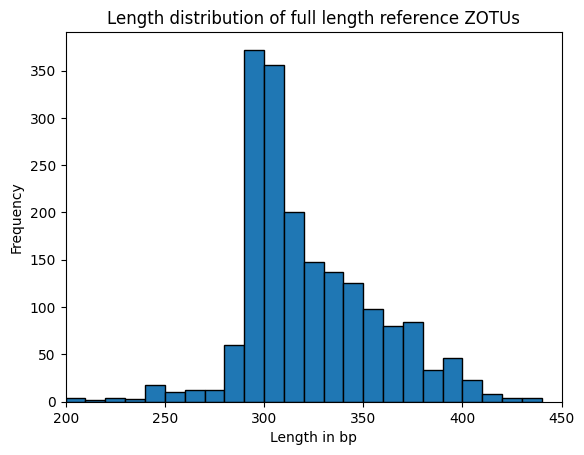

In [100]:
# Length of full length reference ZOTUs
display(md("## Sequence length of reference ZOTUs"))
display(df_refseq_full.describe())
xlim_low, xlim_high = 200, 450
bin_space = 10
bins = [xlim_low + i*bin_space for i in range(int((xlim_high-xlim_low)/bin_space))]
ax = df_refseq_full['refseq_length'].plot.hist(bins=bins, xlim=(xlim_low, xlim_high), edgecolor = "black")
ax.set_title("Length distribution of full length reference ZOTUs")
ax.set_xlabel("Length in bp")

plt.show()

In [11]:
#Comparing reference sequences before and after truncation

df_refseq_both = df[(df["passed_contam_full"]) | (df["passed_contam_trunc"])].drop_duplicates(
    subset=["location", "refsequence_pk_full", "refsequence_pk_trunc"])
df_refseq_both["refseq_full_exclusive_to_loc"] = ~(
    df_refseq_both["refsequence_pk_full"].isin(df_refseq_both[df_refseq_both["location"] == "A"]["refsequence_pk_full"]) &
    df_refseq_both["refsequence_pk_full"].isin(df_refseq_both[df_refseq_both["location"] == "B"]["refsequence_pk_full"]
))
df_refseq_both["refseq_trunc_exclusive_to_loc"] = ~(
    df_refseq_both["refsequence_pk_trunc"].isin(df_refseq_both[df_refseq_both["location"] == "A"]["refsequence_pk_trunc"]) &
    df_refseq_both["refsequence_pk_trunc"].isin(df_refseq_both[df_refseq_both["location"] == "B"]["refsequence_pk_trunc"]
))
df_refseq_both = df_refseq_both.merge(
    df_refseq_both[(df_refseq_both["passed_contam_full"] == True) & (df_refseq_both["passed_contam_trunc"] == True)][["location", "refsequence_pk_trunc"]].drop_duplicates(),
    how="left", indicator=True
).set_index(df_refseq_both.index)
df_refseq_both["refseq_trunc_new_to_loc"] = df_refseq_both["_merge"] == "left_only"
df_refseq_both = df_refseq_both.drop(columns=["_merge"])

df_refseq_both_full = df_refseq_both[df_refseq_both["passed_contam_full"] == True]
df_refseq_both_trunc = df_refseq_both[df_refseq_both["passed_contam_trunc"] == True].drop_duplicates(subset=["location", "passed_contam_full", "refsequence_pk_trunc"])

df_refseq_both_full_count = pd.DataFrame(
    df_refseq_both_full.value_counts(
        subset=["location", "passed_trunc", "refseq_full_exclusive_to_loc", "refseq_trunc_exclusive_to_loc"])
).sort_index(level=["location", "passed_trunc"], sort_remaining=False)

df_refseq_both_trunc_count = pd.DataFrame(
    df_refseq_both_trunc.value_counts(
        subset=["location", "passed_contam_full", "refseq_full_exclusive_to_loc", "refseq_trunc_exclusive_to_loc", "refseq_trunc_new_to_loc"])
).sort_index(level=["location", "passed_contam_full"], sort_remaining=False)

num_ref_full = df_refseq_full.shape[0]
num_ref_trunc = df_refseq.shape[0]

num_ref_full_discarded = df_refseq_both_full_count.loc[(slice(None), False, slice(None), False)]["count"].sum()
num_ref_full_exclusive_both = df_refseq_both_full_count.loc[(slice(None), True, True, True)]["count"].sum()
num_ref_full_not_exclusive_both = df_refseq_both_full_count.loc[("A", True, False, False)]["count"].sum()
num_ref_full_no_longer_exclusive = df_refseq_both_full_count.loc[(slice(None), True, True, False)]["count"].sum()

num_ref_trunc_exclusive_new = df_refseq_both_trunc_count.loc[(slice(None), False, False, True, True)]["count"].sum()
num_ref_trunc_not_exclusive_newA = df_refseq_both_trunc_count.loc[("A", False, False, False, True)]["count"].sum()
num_ref_trunc_not_exclusive_newB = df_refseq_both_trunc_count.loc[("B", False, False, False, True)]["count"].sum()
num_ref_trunc_exclusive_both = df_refseq_both_trunc_count.loc[(slice(None), True, True, True, False)]["count"].sum()
num_ref_trunc_not_exclusive_bothA = df_refseq_both_trunc_count.loc[("A", True, False, False, False)]["count"].sum()
num_ref_trunc_no_longer_exclusiveA = df_refseq_both_trunc_count.loc[("A", True, True, False, False)]["count"].sum()
num_ref_trunc_not_exclusive_bothB = df_refseq_both_trunc_count.loc[("B", True, False, False, False)]["count"].sum()
num_ref_trunc_no_longer_exclusiveB = df_refseq_both_trunc_count.loc[("B", True, True, False, False)]["count"].sum()



display(md("## Comparing reference sequences before and after truncation"))
display(md(f"The number of reference sequences (unique ZOTUs across all samples) is:\n"
           f"- {num_ref_full} at full length\n"
           f"- {num_ref_trunc} when truncating"))
display(md("Of the full length reference sequences:"))
display(df_refseq_both_full_count)
display(md(f"- {num_ref_full_discarded} get discarded (<250bp)\n"
           f"- {num_ref_full_exclusive_both} are exclusive to their location both before and after truncation\n"
           f"- {num_ref_full_not_exclusive_both} are found in both locations before and after truncation\n"
           f"- {num_ref_full_no_longer_exclusive} are no longer exclusive to their location after truncation"))
display(md("Of the truncated reference sequences:"))
display(df_refseq_both_trunc_count)
display(md(f"- {num_ref_trunc_exclusive_new} are new to their location, resulting from the new ZOTUs, and exclusive to their location\n"
           f"- {num_ref_trunc_not_exclusive_newA} are new to location A but not to location B\n"
           f"- {num_ref_trunc_not_exclusive_newB} are new to location B but not to location A\n"
           f"- {num_ref_trunc_exclusive_both} are exclusive to their location both before and after truncation\n"
           f"- {num_ref_trunc_not_exclusive_bothA} are not exclusive to location A before and after truncation\n"
           f"- {num_ref_trunc_no_longer_exclusiveA} are no longer exclusive to location A after truncation\n"
           f"- {num_ref_trunc_not_exclusive_bothB} are not exclusive to location B before and after truncation\n"
           f"- {num_ref_trunc_no_longer_exclusiveB} are no longer exclusive to location B after truncation"
           ))

## Comparing reference sequences before and after truncation

The number of reference sequences (unique ZOTUs across all samples) is:
- 1856 at full length
- 1767 when truncating

Of the full length reference sequences:

count
location passed_trunc refseq_full_exclusive_to_loc refseq_trunc_exclusive_to_loc       
A        False        True                         False                             25
         True         True                         True                             970
                      False                        False                             53
                      True                         False                              5
B        False        True                         False                              6
         True         True                         True                             787
                      False                        False                             53
                      True                         False                             10

- 31 get discarded (<250bp)
- 1757 are exclusive to their location both before and after truncation
- 53 are found in both locations before and after truncation
- 15 are no longer exclusive to their location after truncation

Of the truncated reference sequences:

count
location passed_contam_full refseq_full_exclusive_to_loc refseq_trunc_exclusive_to_loc refseq_trunc_new_to_loc       
A        False              False                        True                          False                      124
                                                                                       True                        21
                                                         False                         False                       12
                                                                                       True                         1
         True               True                         True                          False                      933
                            False                        False                         False                       52
                            True                         False                         False                        2
B        False              False                        True                          False                       60
                                                                                       True                         9
                                                         False                         False                        9
                                                                                       True                         1
         True               True                         True                          False                      749
                            False                        False                         False                       51
                            True                         False                         False                        3

- 30 are new to their location, resulting from the new ZOTUs, and exclusive to their location
- 1 are new to location A but not to location B
- 1 are new to location B but not to location A
- 1682 are exclusive to their location both before and after truncation
- 52 are not exclusive to location A before and after truncation
- 2 are no longer exclusive to location A after truncation
- 51 are not exclusive to location B before and after truncation
- 3 are no longer exclusive to location B after truncation

# Taxonomy table results

In [12]:
# Taxonomic ranks array
ranks = ["phylum", "class", "order", "family", "genus", "species"]

count
passed_trunc tax_missing_full tax_missing_trunc refseq_full_exclusive_to_loc       
False        False            NaN               True                             21
             True             NaN               True                             10
True         False            False             True                           1549
                                                False                            50
             True             False             True                              4
                              True              True                            219
                                                False                             3

- 236 are missing a UNITE hit (12.72%)
	- 10 of these are discarded reference sequences (32.26% of total discarded)
	- 4 of these do have a UNITE hit after truncation (0.22% of reference sequences that pass truncation)
	- 3 of these are are found in both locations (5.66% of reference sequences found in both locations)

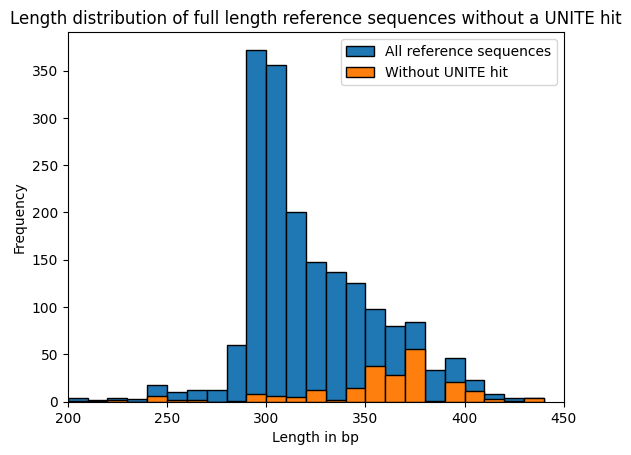

count
passed_contam_full tax_missing_full tax_missing_trunc refseq_trunc_exclusive_to_loc refseq_trunc_new_to_loc       
False              NaN              False             True                          False                      136
                                                                                    True                        23
                                                      False                         False                       15
                                                                                    True                         2
                                    True              True                          False                       48
                                                                                    True                         7
                                                      False                         False                        2
True               False            False             True                          False                     1481
                                                      False                         False                       52
                   True             False             True                          False                        4
                                    True              True                          False                      197
                                                      False                         False                        3

- 207 are missing a UNITE hit (11.71%)
	- 7 of these are new reference sequences (23.33% of new reference sequences)
	- 3 of these are found in both locations (5.45% of reference sequences found in both locations)

In [101]:
#Missing taxonomy analysis

df_refseq_both_full_global = df_refseq_both_full.drop_duplicates(subset=["refsequence_pk_full"])
df_refseq_both_full_global_notax_count = pd.DataFrame(df_refseq_both_full_global.value_counts(
    subset=["passed_trunc", "tax_missing_full", "tax_missing_trunc", "refseq_full_exclusive_to_loc"], dropna=False
)).sort_index(level=["passed_trunc", "tax_missing_full", "tax_missing_trunc"], sort_remaining=False)

df_refseq_both_trunc_global = df_refseq_both_trunc.drop_duplicates(subset=["passed_contam_full", "refsequence_pk_trunc"])
df_refseq_both_trunc_global_notax_count = pd.DataFrame(df_refseq_both_trunc_global.value_counts(
    subset=["passed_contam_full", "tax_missing_full", "tax_missing_trunc", "refseq_trunc_exclusive_to_loc", "refseq_trunc_new_to_loc"], dropna=False
)).sort_index(level=["passed_contam_full", "tax_missing_full", "tax_missing_trunc"], sort_remaining=False)


num_ref_full_notax = df_refseq_both_full_global_notax_count.loc[(slice(None), True, slice(None), slice(None))]["count"].sum()
num_ref_full_notax_discard = df_refseq_both_full_global_notax_count.loc[(False, True, slice(None), slice(None))]["count"].sum()
num_ref_full_notax_no_longer = df_refseq_both_full_global_notax_count.loc[(True, True, False, slice(None))]["count"].sum()
num_ref_full_notax_not_exclusive = df_refseq_both_full_global_notax_count.loc[(True, True, slice(None), False)]["count"].sum()
display(df_refseq_both_full_global_notax_count)

display(md(f"- {num_ref_full_notax} are missing a UNITE hit ({num_ref_full_notax / num_ref_full:.2%})\n"
           f"\t- {num_ref_full_notax_discard} of these are discarded reference sequences ({num_ref_full_notax_discard / num_ref_full_discarded:.2%} of total discarded)\n"
           f"\t- {num_ref_full_notax_no_longer} of these do have a UNITE hit after truncation ({num_ref_full_notax_no_longer / (num_ref_full_exclusive_both + num_ref_full_not_exclusive_both + num_ref_full_no_longer_exclusive):.2%} of reference sequences that pass truncation)\n"
           f"\t- {num_ref_full_notax_not_exclusive} of these are are found in both locations ({num_ref_full_notax_not_exclusive / num_ref_full_not_exclusive_both:.2%} of reference sequences found in both locations)"))

ax = df_refseq_full['refseq_length'].plot.hist(bins=bins, xlim=(200, 450), edgecolor = "black", label="All reference sequences")
df_refseq_both_full_global[df_refseq_both_full_global["tax_missing_full"]]["refseq_length_full"].plot.hist(bins=bins, xlim=(200, 450), edgecolor = "black", ax=ax, label="Without UNITE hit")
ax.set_title("Length distribution of full length reference sequences without a UNITE hit")
ax.set_xlabel("Length in bp")
plt.legend() 
plt.show()


num_ref_trunc_notax_new = df_refseq_both_trunc_global_notax_count.loc[(False, slice(None), True, slice(None), True)]["count"].sum()
num_ref_trunc_notax_overlap = df_refseq_both_trunc_global_notax_count.loc[(True, slice(None), True, slice(None), False)]["count"].sum()
num_ref_trunc_notax = num_ref_trunc_notax_new + num_ref_trunc_notax_overlap
num_ref_trunc_notax_not_exclusive = df_refseq_both_trunc_global_notax_count.loc[(True, slice(None), True, False, False)]["count"].sum()

display(df_refseq_both_trunc_global_notax_count)

display(md(f"- {num_ref_trunc_notax} are missing a UNITE hit ({num_ref_trunc_notax / num_ref_trunc:.2%})\n"
           f"\t- {num_ref_trunc_notax_new} of these are new reference sequences ({num_ref_trunc_notax_new / num_ref_trunc_exclusive_new:.2%} of new reference sequences)\n"
           f"\t- {num_ref_trunc_notax_not_exclusive} of these are found in both locations ({num_ref_trunc_notax_not_exclusive / (num_ref_trunc_not_exclusive_bothA + num_ref_trunc_not_exclusive_newA + num_ref_trunc_no_longer_exclusiveA):.2%} of reference sequences found in both locations)"))


count
location UNITE_id_in_refseq_full UNITE_id_in_refseq_trunc tax_in_refseq_full_lowest tax_in_refseq_trunc_lowest       
A        False                   False                    species                   species                         9
                                                          order                     order                           3
                                                          class                     species                         1
         True                    True                     species                   species                         1
B        False                   False                    species                   species                         1

count
location UNITE_id_in_refseq_full UNITE_id_in_refseq_trunc tax_in_refseq_full_lowest tax_in_refseq_trunc_lowest       
A        True                    True                     species                   species                        10
         False                   False                    species                   species                         3
                                                          family                    family                          2
                                                          order                     order                           2
                                                          species                   class                           1
B        True                    True                     species                   species                         2
         False                   False                    species                   species                         2
                                                          order                     order                           1
                                                          class                     class                           1

count
location UNITE_id_equal tax_equal_lowest       
A        True           species             511
         False          genus                64
                        family               20
                        species              18
                        order                11
                        phylum                9
                        class                 4
B        True           species             318
         False          genus                51
                        family               21
                        species              16
                        order                16
                        phylum                4
                        class                 3

count
tax_missing_full tax_equal_lowest       
False            species             818
                 NaN                 616
True             NaN                 236
False            genus               102
                 family               38
                 order                27
                 phylum               12
                 class                 7

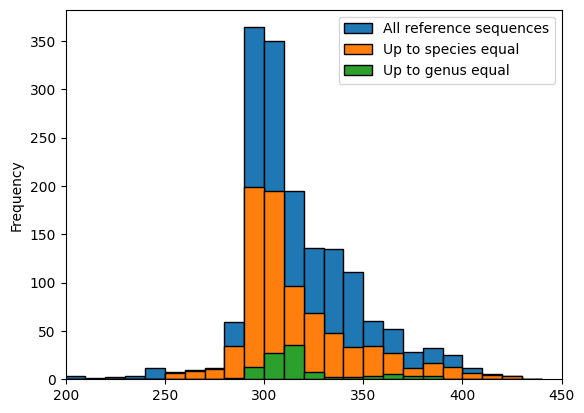

In [113]:
#Create UNITE id dataframes
df_unite_full = df_refseq_both_full[
    df_refseq_both_full["tax_missing_full"] == False].drop_duplicates(subset=["location", "UNITE_id_full"])
df_unite_discard = df_refseq_both_full[
    (df_refseq_both_full["passed_trunc"] == False) & (df_refseq_both_full["tax_missing_full"] == False)].drop_duplicates(subset=["location", "UNITE_id_full"])
df_unite_not_discard = df_refseq_both_full[
    (df_refseq_both_full["passed_trunc"] == True) & (df_refseq_both_full["tax_missing_full"] == False)].drop_duplicates(subset=["location", "UNITE_id_full"])
df_unite_trunc = df_refseq_both_trunc[
    df_refseq_both_trunc["tax_missing_trunc"] == False].drop_duplicates(subset=["location", "UNITE_id_trunc"])
df_unite_new = df_refseq_both_trunc[
    (df_refseq_both_trunc["refseq_trunc_new_to_loc"] == True) & (df_refseq_both_trunc["tax_missing_trunc"] == False)].drop_duplicates(subset=["location", "UNITE_id_trunc"])
df_unite_not_new = df_refseq_both_trunc[
    (df_refseq_both_trunc["refseq_trunc_new_to_loc"] == False) & (df_refseq_both_trunc["tax_missing_trunc"] == False)].drop_duplicates(subset=["location", "UNITE_id_trunc"])
df_unite_both = df_refseq_both[
    (df_refseq_both["tax_missing_full"] == False) & (df_refseq_both["tax_missing_trunc"] == False)].drop_duplicates(subset=["location", "UNITE_id_full", "UNITE_id_trunc"])

# Analyse discarded

for suffix, merge_df in [("full", df_unite_not_discard), ("trunc", df_unite_trunc)]:

    df_unite_discard = df_unite_discard.merge(
        merge_df[["location", f"UNITE_id_{suffix}"]].rename(columns={f"UNITE_id_{suffix}": "UNITE_id_full"}),
        on=["location","UNITE_id_full"], how="left", indicator=True).set_index(df_unite_discard.index)
    df_unite_discard[f"UNITE_id_in_refseq_{suffix}"] = df_unite_discard["_merge"] == "both"
    df_unite_discard = df_unite_discard.drop(columns=["_merge"])

    for rank_depth in range(len(ranks)):
        df_tax_until_rank = merge_df[["location"]+[f"{rank}_{suffix}" for rank in ranks[:rank_depth+1]]].drop_duplicates()
        df_unite_discard = df_unite_discard.merge(
            df_tax_until_rank.rename(columns={f"{rank}_{suffix}": f"{rank}_full" for rank in ranks[:rank_depth+1]}),
            how="left", indicator=True).set_index(df_unite_discard.index)
        df_unite_discard[f"tax_in_refseq_{suffix}_until_{ranks[rank_depth]}"] = df_unite_discard["_merge"] == "both"
        df_unite_discard = df_unite_discard.drop(columns=["_merge"])

    df_unite_discard[f"tax_in_refseq_{suffix}_lowest"] = (
        df_unite_discard[[f"tax_in_refseq_{suffix}_until_{rank}" for rank in ranks]].apply(
            lambda row: next((rank for rank in ranks[::-1] if row[f"tax_in_refseq_{suffix}_until_{rank}"]), None), axis=1
        )
    )


df_unite_discard_counts = pd.DataFrame(df_unite_discard.value_counts(
    subset=["location", "UNITE_id_in_refseq_full", "UNITE_id_in_refseq_trunc", "tax_in_refseq_full_lowest","tax_in_refseq_trunc_lowest"])
    ).sort_index(level=["location"], sort_remaining=False)


display(df_unite_discard_counts)

# Analyze new refseqs

for suffix, merge_df in [("full", df_unite_full), ("trunc", df_unite_not_new)]:

    df_unite_new = df_unite_new.merge(
        merge_df[["location", f"UNITE_id_{suffix}"]].rename(columns={f"UNITE_id_{suffix}": "UNITE_id_trunc"}),
        on=["location","UNITE_id_trunc"], how="left", indicator=True).set_index(df_unite_new.index)
    df_unite_new[f"UNITE_id_in_refseq_{suffix}"] = df_unite_new["_merge"] == "both"
    df_unite_new = df_unite_new.drop(columns=["_merge"])

    for rank_depth in range(len(ranks)):
        df_tax_until_rank = merge_df[["location"]+[f"{rank}_{suffix}" for rank in ranks[:rank_depth+1]]].drop_duplicates()
        df_unite_new = df_unite_new.merge(
            df_tax_until_rank.rename(columns={f"{rank}_{suffix}": f"{rank}_trunc" for rank in ranks[:rank_depth+1]}),
            how="left", indicator=True).set_index(df_unite_new.index)
        df_unite_new[f"tax_in_refseq_{suffix}_until_{ranks[rank_depth]}"] = df_unite_new["_merge"] == "both"
        df_unite_new = df_unite_new.drop(columns=["_merge"])

    df_unite_new[f"tax_in_refseq_{suffix}_lowest"] = (
        df_unite_new[[f"tax_in_refseq_{suffix}_until_{rank}" for rank in ranks]].apply(
            lambda row: next((rank for rank in ranks[::-1] if row[f"tax_in_refseq_{suffix}_until_{rank}"]), None), axis=1
        )
    )

df_unite_new_counts = pd.DataFrame(df_unite_new.value_counts(
    subset=["location", "UNITE_id_in_refseq_full", "UNITE_id_in_refseq_trunc", "tax_in_refseq_full_lowest","tax_in_refseq_trunc_lowest"])
).sort_index(level=["location"], sort_remaining=False)

display(df_unite_new_counts)

# Analyze refseqs that only truncated have a UNITE hit
# skip

# Analyze refseqs that have a UNITE hit before and after truncation
df_unite_both["UNITE_id_equal"] = df_unite_both["UNITE_id_full"] == df_unite_both["UNITE_id_trunc"]

for rank in ranks:
    df_unite_both[f"{rank}_equal"] = df_unite_both[f"{rank}_full"] == df_unite_both[f"{rank}_trunc"]

df_unite_both["tax_equal_lowest"] = (
    df_unite_both[[f"{rank}_equal" for rank in ranks]].apply(
        lambda row: next((rank for rank in ranks[::-1] if row[f"{rank}_equal"]), None), axis=1
    )
)

df_unite_both_count = pd.DataFrame(
    df_unite_both.value_counts(subset=["location", "UNITE_id_equal", "tax_equal_lowest"])).sort_index(level="location", sort_remaining=False)

display(df_unite_both_count)

df_unite_both_global = df_unite_both.drop_duplicates(subset=["UNITE_id_full", "UNITE_id_trunc"])
df_refseq_both_full_global_tax = df_refseq_both_full_global.merge(df_unite_both_global[["refsequence_pk_full", "UNITE_id_full", "tax_equal_lowest"]], how="left")
display(pd.DataFrame(df_refseq_both_full_global_tax.value_counts(subset=["tax_missing_full", "tax_equal_lowest"], dropna=False)))

#df_refseq_both_full_global_species = df_refseq_both_full_global[
#    df_refseq_both_full_global["UNITE_id_full"].isin(df_unite_both[df_unite_both["tax_equal_lowest"] == "species"]["UNITE_id_full"])]
#df_refseq_both_full_global_genus = df_refseq_both_full_global[
#    df_refseq_both_full_global["UNITE_id_full"].isin(df_unite_both[df_unite_both["tax_equal_lowest"] == "genus"]["UNITE_id_full"])]
#df_refseq_both_full_global_family = df_refseq_both_full_global[
#    df_refseq_both_full_global["UNITE_id_full"].isin(df_unite_both[df_unite_both["tax_equal_lowest"] == "family"]["UNITE_id_full"])]


ax = df_refseq_both_full_global_tax[df_refseq_both_full_global_tax["tax_missing_full"] == False]["refseq_length_full"].plot.hist(bins=bins, xlim=(200, 450), edgecolor = "black", label="All reference sequences")
df_refseq_both_full_global_tax[df_refseq_both_full_global_tax["tax_equal_lowest"] == "species"]['refseq_length_full'].plot.hist(bins=bins, xlim=(200, 450), edgecolor = "black", ax=ax, label="Up to species equal")
df_refseq_both_full_global_tax[df_refseq_both_full_global_tax["tax_equal_lowest"] == "genus"]['refseq_length_full'].plot.hist(bins=bins, xlim=(200, 450), edgecolor = "black", ax=ax, label="Up to genus equal")

#df_refseq_both_full_global_genus['refseq_length_full'].plot.hist(bins=bins, xlim=(200, 450), edgecolor = "black", ax=ax, label="Up to genus equal")
#df_refseq_both_full_global_family['refseq_length_full'].plot.hist(bins=bins, xlim=(200, 450), edgecolor = "black", ax=ax, label="Up to family equal")

plt.legend()
plt.show()



In [15]:
#Taxonomic differences on ZOTUs that pass at full length and after truncation

df_trunc_refseq_both_tax_missing_count = pd.DataFrame(df_trunc_refseq_both.value_counts(subset=["location", "tax_missing_full", "tax_missing_trunc"]))

df_trunc_unite_both_new = df_trunc_refseq_both[df_trunc_refseq_both["tax_missing_full"] != df_trunc_refseq_both["tax_missing_trunc"]].drop_duplicates(subset=["location", "UNITE_id_trunc"])

df_trunc_unite_refseq_trunc_sans_both_new = df_trunc[(df_trunc["passed_contam_trunc"] == True) & (df_trunc["tax_missing_trunc"] == False)].drop(index=df_trunc_unite_both_new.index).drop_duplicates(subset=["location", "UNITE_id_trunc"])

df_trunc_unite_both_new = df_trunc_unite_both_new.merge(
    df_trunc_unite_refseq_trunc_sans_both_new[["location", "UNITE_id_trunc"]],
    on=["location","UNITE_id_trunc"], how="left", indicator=True).set_index(df_trunc_unite_both_new.index)
df_trunc_unite_both_new["UNITE_id_in_refseq_trunc"] = df_trunc_unite_both_new["_merge"] == "both"
df_trunc_unite_both_new = df_trunc_unite_both_new.drop(columns=["_merge"])

for level_depth in range(len(levels)):
    df_trunc_tax_trunc_until_level = df_trunc_unite_refseq_trunc_sans_both_new[["location"]+[f"{level}_trunc" for level in levels[:level_depth+1]]].drop_duplicates()
    df_trunc_unite_both_new = df_trunc_unite_both_new.merge(
        df_trunc_tax_trunc_until_level, how="left", indicator=True).set_index(df_trunc_unite_both_new.index)
    df_trunc_unite_both_new[f"tax_in_refseq_trunc_until_{levels[level_depth]}"] = df_trunc_unite_both_new["_merge"] == "both"
    df_trunc_unite_both_new = df_trunc_unite_both_new.drop(columns=["_merge"])

df_trunc_unite_both_new["tax_in_refseq_lowest"] = (
    df_trunc_unite_both_new[[f"tax_in_refseq_trunc_until_{level}" for level in levels]].apply(
        lambda row: next((level for level in levels[::-1] if row[f"tax_in_refseq_trunc_until_{level}"]), None), axis=1
    )
)

df_trunc_unite_both_new_counts = pd.DataFrame(df_trunc_unite_both_new.value_counts(
    subset=["location", "UNITE_id_in_refseq_trunc", "tax_in_refseq_lowest"]+[f"{level}_trunc" for level in levels]))

num_trunc_refseq_both = df_trunc_refseq_both.shape[0]
num_trunc_refseq_both_trunc = df_trunc_refseq_both.drop_duplicates(subset=["location", "refsequence_pk_trunc"]).shape[0]
num_trunc_refseq_both_unite = df_trunc_refseq_both_tax_missing_count.loc[(slice(None), False, False)]["count"].sum()
num_trunc_refseq_both_unite_na = df_trunc_refseq_both_tax_missing_count.loc[(slice(None), True, True)]["count"].sum()
num_trunc_refseq_both_unite_new = df_trunc_refseq_both_tax_missing_count.loc[(slice(None), True, False)]["count"].sum()
num_trunc_refseq_both_unite_new_elsewhere = df_trunc_unite_both_new[df_trunc_unite_both_new["UNITE_id_in_refseq_trunc"] == True].shape[0]
display(md(f"Of the {num_trunc_refseq_both} full length reference sequences that map to {num_trunc_refseq_both_trunc} truncated reference sequences:"))
display(df_trunc_refseq_both_tax_missing_count)
display(md(f"- {num_trunc_refseq_both_unite} have UNITE hits before and after truncation\n"
           f"- {num_trunc_refseq_both_unite_na} do not have UNITE hits both at full length and truncated\n"
           f"- {num_trunc_refseq_both_unite_new} no longer have missing UNITE hits after truncation"))
display(df_trunc_unite_both_new_counts)
display(md(f"- {num_trunc_refseq_both_unite_new_elsewhere} of these truncated reference sequences map to a UNITE id that is also present elsewhere in the truncated reference sequences"))

# ---

df_trunc_unite_both = df_trunc_refseq_both[
    (df_trunc_refseq_both["tax_missing_full"] == False) &
    (df_trunc_refseq_both["tax_missing_trunc"] == False)].copy()
df_trunc_unite_both["UNITE_id_equal"] = df_trunc_unite_both["UNITE_id_full"] == df_trunc_unite_both["UNITE_id_trunc"]

for level in levels:
    df_trunc_unite_both[f"{level}_equal"] = df_trunc_unite_both[f"{level}_full"] == df_trunc_unite_both[f"{level}_trunc"]

df_trunc_unite_both["tax_equal_lowest"] = (
    df_trunc_unite_both[[f"{level}_equal" for level in levels]].apply(
        lambda row: next((level for level in levels[::-1] if row[f"{level}_equal"]), None), axis=1
    )
)

df_trunc_unite_both["UNITE_id_full_exclusive_to_loc"] = ~(
    df_trunc_unite_both["UNITE_id_full"].isin(df_trunc_unite_both[df_trunc_unite_both["location"] == "A"]["UNITE_id_full"]) &
    df_trunc_unite_both["UNITE_id_full"].isin(df_trunc_unite_both[df_trunc_unite_both["location"] == "B"]["UNITE_id_full"]
))

df_trunc_unite_both["UNITE_id_trunc_exclusive_to_loc"] = ~(
    df_trunc_unite_both["UNITE_id_trunc"].isin(df_trunc_unite_both[df_trunc_unite_both["location"] == "A"]["UNITE_id_trunc"]) &
    df_trunc_unite_both["UNITE_id_trunc"].isin(df_trunc_unite_both[df_trunc_unite_both["location"] == "B"]["UNITE_id_trunc"]
))

df_trunc_unite_both_exclusive_both = df_trunc_unite_both[
    (df_trunc_unite_both["refseq_full_exclusive_to_loc"] == True) &
    (df_trunc_unite_both["refseq_trunc_exclusive_to_loc"] == True)].drop_duplicates(subset=["location", "UNITE_id_full", "UNITE_id_trunc"])

display(pd.DataFrame(df_trunc_unite_both_exclusive_both.value_counts(subset=["location", "UNITE_id_equal", "tax_equal_lowest"])).sort_index(level="location", sort_remaining=False))


NameError: name 'df_trunc_refseq_both' is not defined

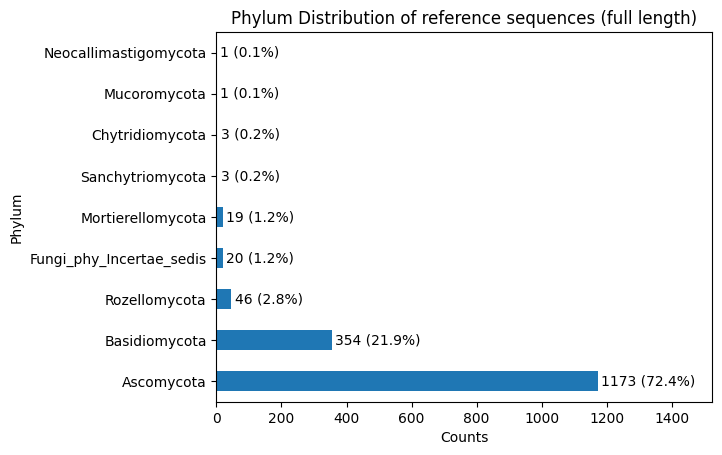

refseq_length                                       \
                                 count        mean       std    min     25%   
phylum                                                                        
Ascomycota                         4.0  207.250000  5.188127  204.0  204.75   
Fungi_phy_Incertae_sedis           4.0  233.500000  9.882645  223.0  226.75   
Rozellomycota                     13.0  244.153846  3.555422  239.0  242.00   

                                                
                            50%     75%    max  
phylum                                          
Ascomycota                205.0  207.50  215.0  
Fungi_phy_Incertae_sedis  233.0  239.75  245.0  
Rozellomycota             243.0  247.00  249.0

In [ ]:
value_counts = df_refseq_tax_full["phylum"].value_counts()
proportions = value_counts / value_counts.sum()
ax = value_counts.plot.barh(xlim=(0, value_counts.max() * 1.3))

for index, (count, proportion) in enumerate(zip(value_counts, proportions)):
    ax.text(count + 10, index, f"{count} ({proportion:.1%})", va='center')

ax.set_xlabel("Counts")
ax.set_ylabel("Phylum")
ax.set_title("Phylum Distribution of reference sequences (full length)")

plt.show()

df_refseq_full[df_refseq_full["refseq_length"] < 250].merge(df_refseq_tax_full)[["phylum", "refseq_length"]].groupby("phylum").describe()
#df_refseq_full.merge(df_refseq_tax_full)[["phylum", "refseq_length"]].groupby("phylum").median().plot.barh()

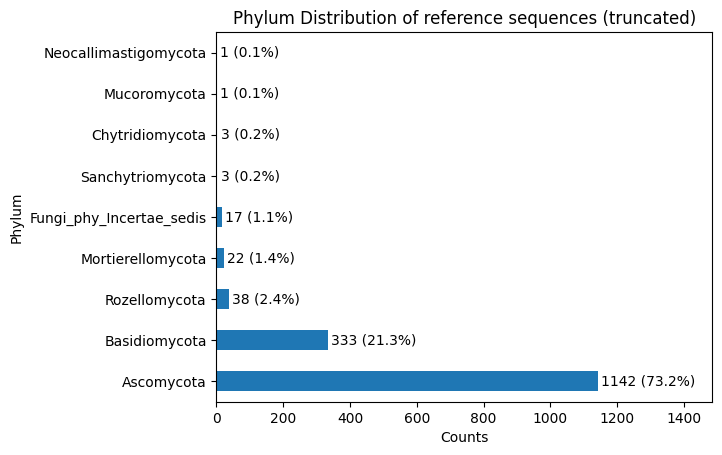

In [ ]:
value_counts = df_refseq_tax["phylum"].value_counts()
proportions = value_counts / value_counts.sum()
ax = value_counts.plot.barh(xlim=(0, value_counts.max() * 1.3))

for index, (count, proportion) in enumerate(zip(value_counts, proportions)):
    ax.text(count + 10, index, f"{count} ({proportion:.1%})", va='center')

ax.set_xlabel("Counts")
ax.set_ylabel("Phylum")
ax.set_title("Phylum Distribution of reference sequences (truncated)")

plt.show()

# Full length reference table

## Sequence length of reference ZOTUs

,refseq_length
count,1856.000000
mean,322.687500
std,35.298212
min,204.000000
25%,298.750000
50%,312.000000
75%,342.000000
max,478.000000


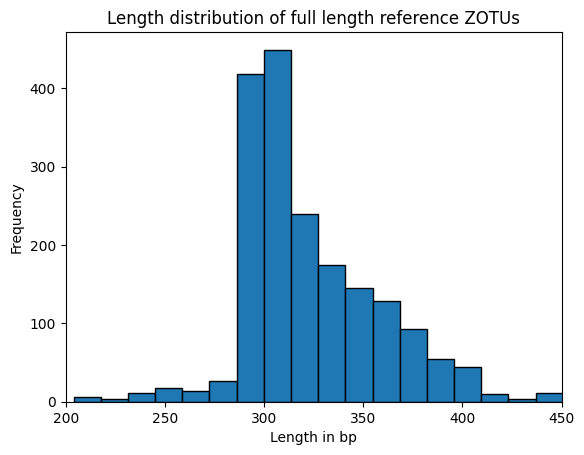